# Predictive Modeling: Resolution Time Prediction

In this notebook, we predict how long it takes for PyTorch forum questions to get resolved, based on question characteristics such as CUDA tags, code snippets, and engagement metrics.

## Goals
1. Build simple and multiple regression models
2. Test non-linear relationships
3. Perform feature selection
4. Evaluate and compare predictive performance  

## Setup

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('..')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Configure plotting
sns.set_context('talk')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

print("Setup complete!")

Setup complete!


## Load and Prepare Data

In [21]:
# Load data
df = pd.read_csv('../data/processed/forum_data.csv')

# Filter to resolved topics only
df_resolved = df[df['time_to_resolution_hours'].notna()].copy()

print(f"Total resolved topics: {len(df_resolved):,}")

# Remove outliers (>99th percentile)
threshold = df_resolved['time_to_resolution_hours'].quantile(0.99)
df_resolved = df_resolved[df_resolved['time_to_resolution_hours'] <= threshold]

df_viz = df_resolved.copy()

print(f"After removing outliers: {len(df_resolved):,}")

Total resolved topics: 13,409
After removing outliers: 13,274


In [22]:
# Feature engineering for exploratory analysis
bool_cols = ['is_cuda_related', 'has_code_block', 'has_error_trace']
df_resolved[bool_cols] = df_resolved[bool_cols].astype(int)

df_resolved['code_density'] = df_resolved['code_block_count'] / (df_resolved['question_length'] + 1)
df_resolved['engagement_score'] = (
    df_resolved['views'] + df_resolved['reply_count']
) / (df_resolved['question_length'] + 1)


### Data Overview

In [23]:
# Summarize key statistics
numeric_cols = [
    col for col in df_resolved.select_dtypes(include=[np.number]).columns
    if col != 'time_to_resolution_hours'
]
summary_stats = (
    df_resolved[['time_to_resolution_hours'] + numeric_cols]
    .describe()
    .T
    .rename(columns={'50%': 'median'})
)
summary_stats[['mean', 'std', 'min', '25%', 'median', '75%', 'max']] = (
    summary_stats[['mean', 'std', 'min', '25%', 'median', '75%', 'max']].round(2)
)

display(summary_stats.head(12).style.background_gradient(cmap='Blues'))

,count,mean,std,min,25%,median,75%,max
time_to_resolution_hours,13274.000000,81.410000,425.630000,0.010000,1.770000,8.570000,28.150000,6829.110000
topic_id,13274.000000,118629.730000,50425.830000,322.000000,78993.000000,115265.500000,158562.500000,223694.000000
category_id,13274.000000,5.930000,7.900000,1.000000,1.000000,5.000000,7.000000,44.000000
views,13274.000000,3394.510000,13406.000000,15.000000,536.250000,1079.000000,2487.000000,844914.000000
reply_count,13274.000000,4.040000,5.330000,1.000000,2.000000,3.000000,5.000000,149.000000
like_count,13274.000000,2.350000,11.720000,0.000000,0.000000,1.000000,2.000000,579.000000
is_cuda_related,13274.000000,0.340000,0.470000,0.000000,0.000000,0.000000,1.000000,1.000000
has_code_block,13274.000000,0.710000,0.460000,0.000000,0.000000,1.000000,1.000000,1.000000
code_block_count,13274.000000,1.170000,1.360000,0.000000,0.000000,1.000000,2.000000,16.000000
question_length,13274.000000,1644.700000,2513.930000,21.000000,433.000000,851.000000,1805.000000,31992.000000


In [24]:
# Data quality checks
missing_pct = (df_resolved.isna().mean().sort_values(ascending=False) * 100).round(2)
missing_summary = missing_pct[missing_pct > 0]

record_duplicates = df_resolved.duplicated(subset=['topic_id']).sum()

print("Rows:", f"{len(df_resolved):,}")
print("Columns:", len(df_resolved.columns))
print("Potential topic duplicates:", record_duplicates)
print()

if not missing_summary.empty:
    display(missing_summary.to_frame('missing_%'))
else:
    print("No missing values detected after filtering resolved topics.")

Rows: 13,274
Columns: 20
Potential topic duplicates: 0

No missing values detected after filtering resolved topics.


### Data Quality Checks

### Exploratory Analysis

We start by looking at how resolution times are distributed and how they vary with high-level tags. This helps ground the modeling results that come later.

C:\Users\cyber\AppData\Local\Temp\ipykernel_3864\949358939.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\cyber\AppData\Local\Temp\ipykernel_3864\949358939.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Non-CUDA', 'CUDA'])


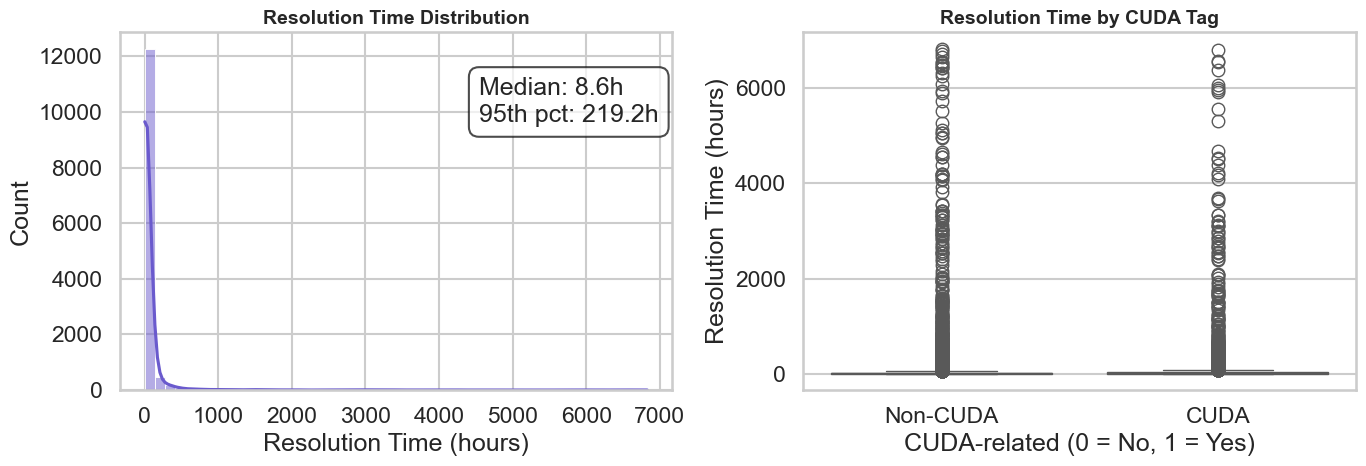

In [25]:
# Distribution of resolution times
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(
    df_resolved['time_to_resolution_hours'],
    bins=50,
    kde=True,
    ax=axes[0],
    color='slateblue'
)
axes[0].set_title('Resolution Time Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Resolution Time (hours)')
axes[0].set_ylabel('Count')
axes[0].annotate(
    f"Median: {df_resolved['time_to_resolution_hours'].median():.1f}h\n95th pct: {df_resolved['time_to_resolution_hours'].quantile(0.95):.1f}h",
    xy=(0.65, 0.75),
    xycoords='axes fraction',
    bbox=dict(boxstyle='round,pad=0.4', fc='white', ec='black', alpha=0.7)
)

sns.boxplot(
    x='is_cuda_related',
    y='time_to_resolution_hours',
    data=df_resolved,
    ax=axes[1],
    palette='Set2'
)
axes[1].set_title('Resolution Time by CUDA Tag', fontsize=14, fontweight='bold')
axes[1].set_xlabel('CUDA-related (0 = No, 1 = Yes)')
axes[1].set_ylabel('Resolution Time (hours)')
axes[1].set_xticklabels(['Non-CUDA', 'CUDA'])

plt.tight_layout()
plt.show()

C:\Users\cyber\AppData\Local\Temp\ipykernel_3864\1618876953.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


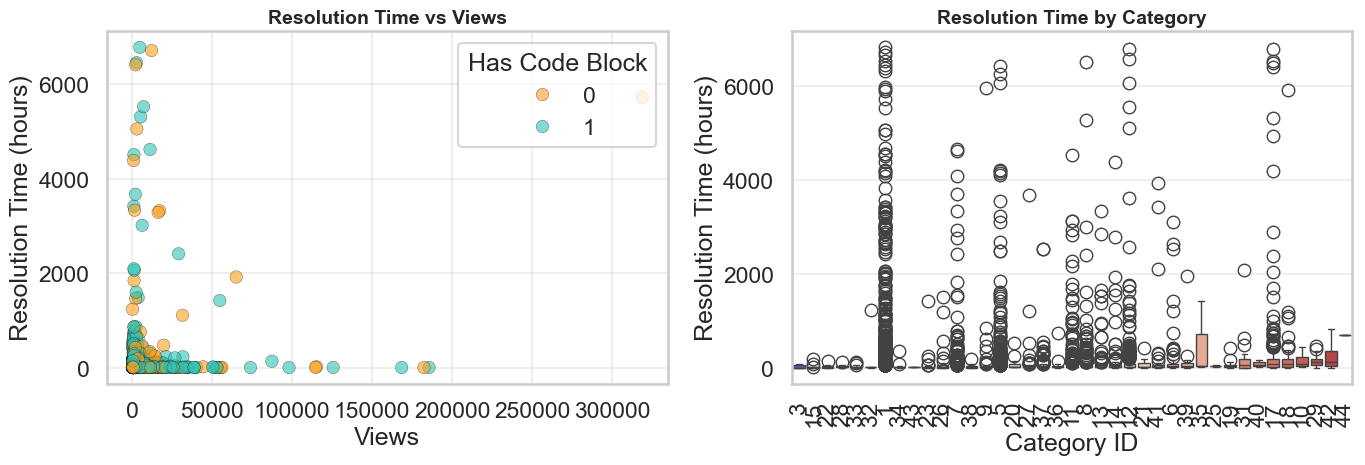

In [26]:
# Relationship between engagement and resolution time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(
    data=df_resolved.sample(min(2000, len(df_resolved)), random_state=42),
    x='views',
    y='time_to_resolution_hours',
    hue='has_code_block',
    palette=['#FF9F1C', '#2EC4B6'],
    ax=axes[0],
    alpha=0.6,
    edgecolor='black',
    linewidth=0.3
)
axes[0].set_xlabel('Views')
axes[0].set_ylabel('Resolution Time (hours)')
axes[0].set_title('Resolution Time vs Views', fontsize=14, fontweight='bold')
axes[0].legend(title='Has Code Block', loc='upper right')
axes[0].grid(alpha=0.3)

sns.boxplot(
    data=df_resolved,
    x='category_id',
    y='time_to_resolution_hours',
    order=df_resolved.groupby('category_id')['time_to_resolution_hours'].median().sort_values().index,
    ax=axes[1],
    palette='coolwarm'
)
axes[1].set_xlabel('Category ID')
axes[1].set_ylabel('Resolution Time (hours)')
axes[1].set_title('Resolution Time by Category', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### Correlation Heatmap

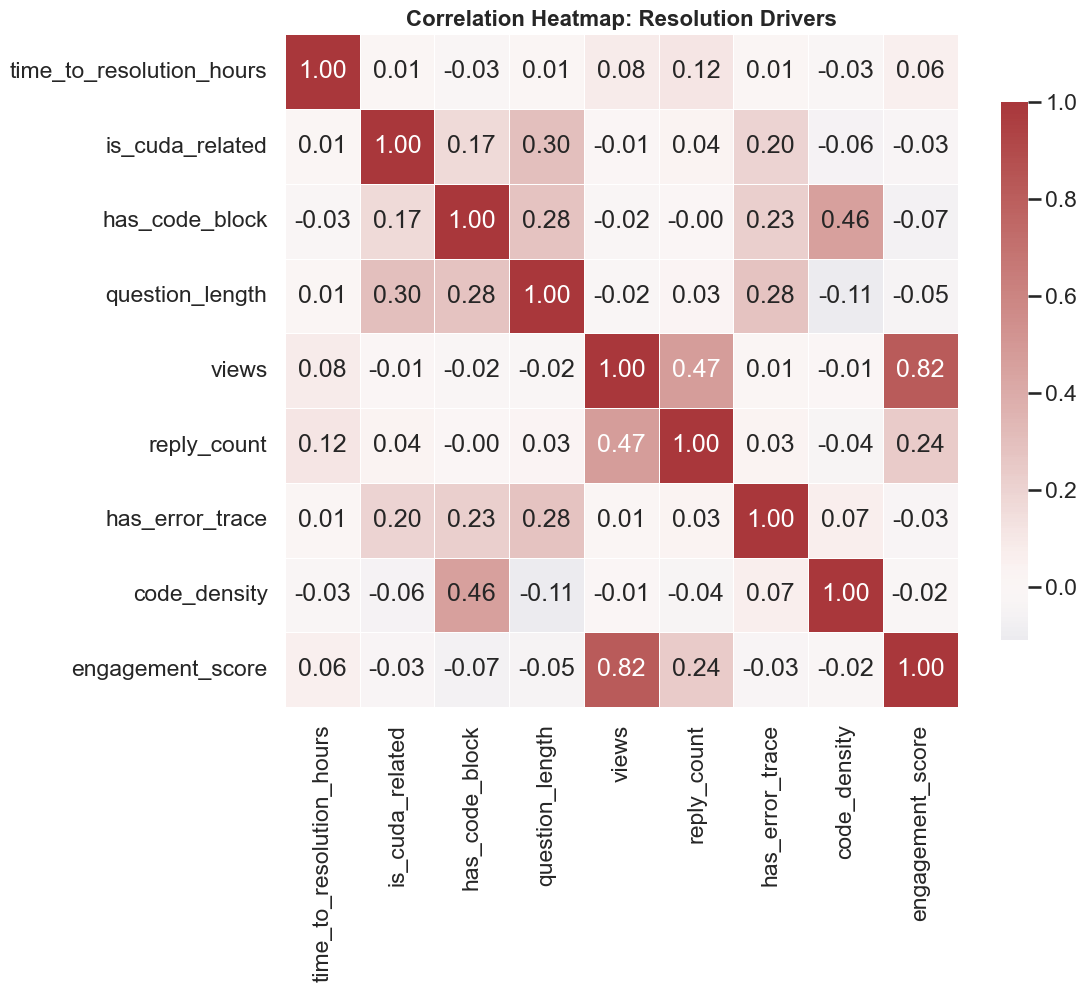

In [27]:
# Correlation heatmap with top features
plt.figure(figsize=(12, 10))
selected_cols = [
    'time_to_resolution_hours',
    'is_cuda_related',
    'has_code_block',
    'question_length',
    'views',
    'reply_count',
    'has_error_trace',
    'code_density',
    'engagement_score'
]
corr_matrix = df_resolved[selected_cols].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='vlag',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title('Correlation Heatmap: Resolution Drivers', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Feature Relationships

We next explore how resolution time behaves with key behavioral signals and categories.

In [28]:
# === FEATURE SELECTION AND ENGINEERING ===
# Base features
feature_cols = [
    'is_cuda_related', 'has_code_block', 'code_block_count',
    'question_length', 'has_error_trace', 'views', 'reply_count', 'hour_of_day'
]

# Create engineered features for richer representation
df_resolved['code_density'] = df_resolved['code_block_count'] / (df_resolved['question_length'] + 1)
df_resolved['engagement_score'] = (df_resolved['views'] + df_resolved['reply_count']) / (df_resolved['question_length'] + 1)

feature_cols.extend(['code_density', 'engagement_score'])

# Convert booleans to integers
for col in ['is_cuda_related', 'has_code_block', 'has_error_trace']:
    df_resolved[col] = df_resolved[col].astype(int)

# One-hot encode categories
df_resolved = pd.get_dummies(df_resolved, columns=['category_id'], prefix='cat', drop_first=True)
category_cols = [col for col in df_resolved.columns if col.startswith('cat_')]
feature_cols.extend(category_cols)

print(f" Total features: {len(feature_cols)}")

 Total features: 48


In [29]:
# Train/test split
X = df_resolved[feature_cols]
y = df_resolved['time_to_resolution_hours']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Training set: 10,619 samples
Test set: 2,655 samples


In [30]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Try extracting coefficients (if model has them)
    try:
        intercept = model.named_steps['regressor'].intercept_
        coefficients = model.named_steps['regressor'].coef_
    except AttributeError:
        # Direct model (not a pipeline)
        try:
            intercept = model.intercept_
            coefficients = model.coef_
        except AttributeError:
            intercept, coefficients = None, None

    return {
        'Model': name,
        'Train R²': r2_score(y_train, y_pred_train),
        'Test R²': r2_score(y_test, y_pred_test),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Intercept': intercept,
        'Coefficients': coefficients
    }

## Model 1: Simple Linear Regression

Baseline model: `time ~ is_cuda_related`

In [31]:
X_train_simple = X_train[['is_cuda_related']]
X_test_simple = X_test[['is_cuda_related']]

model_simple = LinearRegression()
simple_result = evaluate_model("Simple Linear", model_simple, X_train_simple, X_test_simple, y_train, y_test)

print("=== SIMPLE LINEAR REGRESSION ===")
print(f"Training R²: {simple_result['Train R²']:.4f}")
print(f"Test R²: {simple_result['Test R²']:.4f}")
print(f"Test MAE: {simple_result['Test MAE']:.2f} hours")
print(f"Test RMSE: {simple_result['Test RMSE']:.2f} hours")
print(f"\nCUDA Effect: {simple_result['Coefficients'][0]:.2f} hours")
print(f"Intercept: {simple_result['Intercept']:.2f} hours")

=== SIMPLE LINEAR REGRESSION ===
Training R²: 0.0002
Test R²: -0.0001
Test MAE: 123.47 hours
Test RMSE: 463.34 hours

CUDA Effect: 13.13 hours
Intercept: 75.66 hours


## Model 2: Multiple Linear Regression

Full model with all features

In [32]:
# Multiple regression with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Evaluate model using helper
multi_result = evaluate_model("Multiple Linear", pipeline, X_train, X_test, y_train, y_test)

# Print results
print("=== MULTIPLE LINEAR REGRESSION ===")
print(f"Training R²: {multi_result['Train R²']:.4f}")
print(f"Test R²: {multi_result['Test R²']:.4f}")
print(f"Test MAE: {multi_result['Test MAE']:.2f} hours")
print(f"Test RMSE: {multi_result['Test RMSE']:.2f} hours")

# Cross-validation (5-fold)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"\n5-Fold CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== MULTIPLE LINEAR REGRESSION ===
Training R²: 0.0286
Test R²: 0.0170
Test MAE: 119.08 hours
Test RMSE: 459.35 hours

5-Fold CV R²: 0.0175 (+/- 0.0201)

5-Fold CV R²: 0.0175 (+/- 0.0201)



Top 15 Most Important Features:
             feature  coefficient
6        reply_count    50.320292
22            cat_17    28.911917
18            cat_12    20.095733
12             cat_6    13.321421
23            cat_18    13.225833
19            cat_13     9.892237
15             cat_9     9.838350
1     has_code_block    -9.083615
17            cat_11     8.841144
14             cat_8     8.586835
20            cat_14     8.585728
34            cat_31     8.011365
44            cat_41     7.751860
45            cat_42     7.108392
9   engagement_score     6.832641


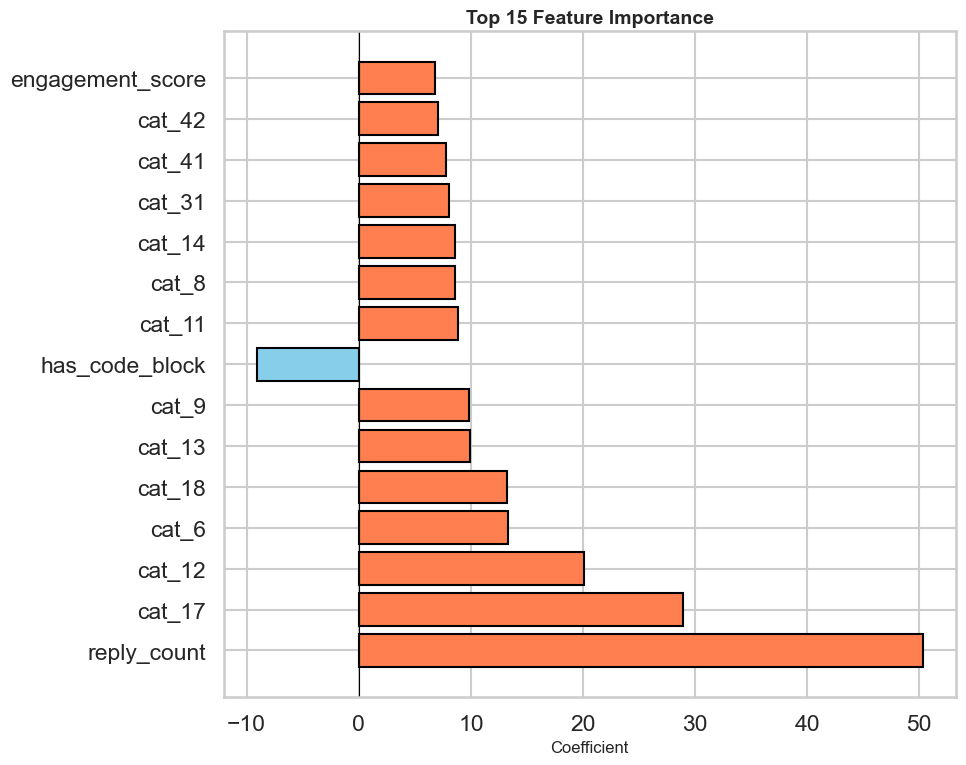

In [33]:
# Feature importance
regressor = pipeline.named_steps['regressor']
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': regressor.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 15 Most Important Features:")
print(coef_df.head(15))

plt.figure(figsize=(10, 8))
top_features = coef_df.head(15)
colors = ['coral' if x > 0 else 'skyblue' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient', fontsize=12)
plt.title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

## Model 3: Polynomial Regression

Add interaction terms and squared terms

In [34]:
# Add interaction: is_cuda * has_code_block
X_train_poly = X_train.copy()
X_test_poly = X_test.copy()

# Interaction term: CUDA × Code Block
X_train_poly['cuda_x_code'] = X_train_poly['is_cuda_related'] * X_train_poly['has_code_block']
X_test_poly['cuda_x_code'] = X_test_poly['is_cuda_related'] * X_test_poly['has_code_block']

# Squared term: Question Length²
X_train_poly['question_length_sq'] = X_train_poly['question_length'] ** 2
X_test_poly['question_length_sq'] = X_test_poly['question_length'] ** 2

pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

poly_result = evaluate_model("Polynomial", pipeline_poly, X_train_poly, X_test_poly, y_train, y_test)

print("\n=== POLYNOMIAL REGRESSION ===")
print(f"Training R²: {poly_result['Train R²']:.4f}")
print(f"Test R²: {poly_result['Test R²']:.4f}")
print(f"Test MAE: {poly_result['Test MAE']:.2f} hours")
print(f"Test RMSE: {poly_result['Test RMSE']:.2f} hours")


=== POLYNOMIAL REGRESSION ===
Training R²: 0.0289
Test R²: 0.0178
Test MAE: 118.99 hours
Test RMSE: 459.17 hours


## Model 4: Lasso Regression

L1 regularization for automatic feature selection

In [35]:
# Lasso regression
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LassoCV(cv=5, random_state=42, max_iter=10000))
])

lasso_result = evaluate_model("Lasso", pipeline_lasso, X_train, X_test, y_train, y_test)

print("\n=== LASSO REGRESSION ===")
print(f"Training R²: {lasso_result['Train R²']:.4f}")
print(f"Test R²: {lasso_result['Test R²']:.4f}")
print(f"Test MAE: {lasso_result['Test MAE']:.2f} hours")
print(f"Test RMSE: {lasso_result['Test RMSE']:.2f} hours")

# Feature selection summary
regressor = pipeline_lasso.named_steps['regressor']
selected = [(feat, coef) for feat, coef in zip(feature_cols, regressor.coef_) if abs(coef) > 0.01]

print(f"\nSelected {len(selected)} features (out of {len(feature_cols)})")
print("\nTop selected features (by absolute weight):")
for feat, coef in sorted(selected, key=lambda x: abs(x[1]), reverse=True)[:10]:
    print(f"  {feat}: {coef:.4f}")


=== LASSO REGRESSION ===
Training R²: 0.0278
Test R²: 0.0177
Test MAE: 118.95 hours
Test RMSE: 459.21 hours

Selected 25 features (out of 48)

Top selected features (by absolute weight):
  reply_count: 48.6000
  cat_17: 26.5700
  cat_12: 17.9288
  cat_6: 11.1928
  cat_18: 10.9571
  cat_9: 7.5867
  cat_13: 7.4099
  cat_11: 6.5904
  cat_14: 6.4877
  cat_8: 6.4357


## Model Comparison


=== MODEL COMPARISON ===
             Model  Test R²  Test MAE
0    Simple Linear   -0.000   123.471
1  Multiple Linear    0.017   119.079
2       Polynomial    0.018   118.990
3            Lasso    0.018   118.954


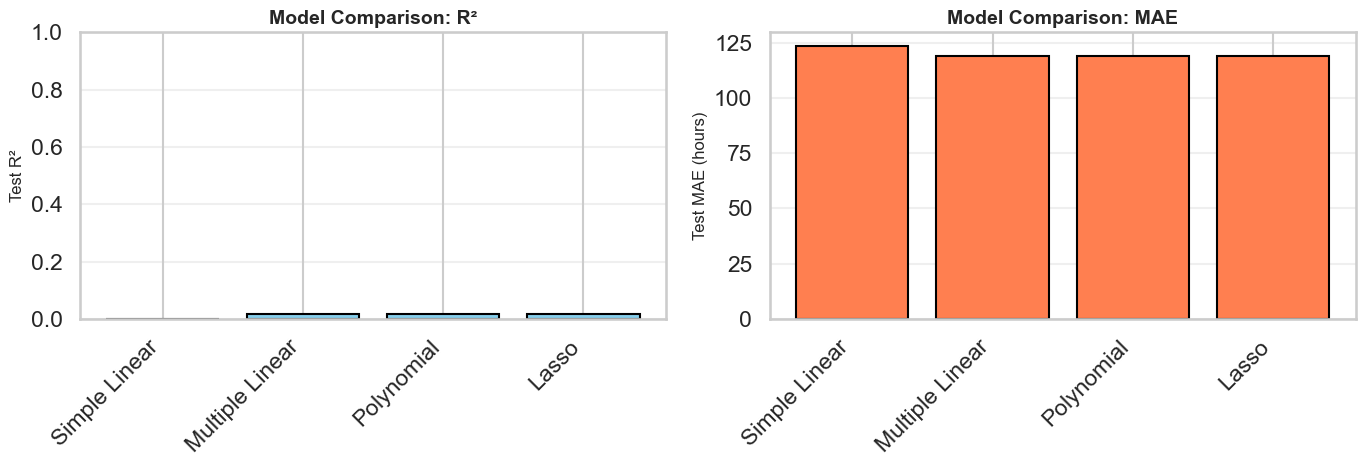

In [36]:
# === MODEL COMPARISON (Dynamic) ===

# Evaluate model results dynamically (renamed to avoid clash with earlier function)
def evaluate_model_dynamic(name, model, X_test, y_test):
    """Evaluate trained model on test data (for comparison table)."""
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Test R²': r2_score(y_test, y_pred),
        'Test MAE': mean_absolute_error(y_test, y_pred)
    }

# Collect results from all trained models
results = [
    evaluate_model_dynamic('Simple Linear', model_simple, X_test_simple, y_test),
    evaluate_model_dynamic('Multiple Linear', pipeline, X_test, y_test),
    evaluate_model_dynamic('Polynomial', pipeline_poly, X_test_poly, y_test),
    evaluate_model_dynamic('Lasso', pipeline_lasso, X_test, y_test)
]

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print("\n=== MODEL COMPARISON ===")
print(results_df.round(3))

# === Visualization (same logic preserved) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
axes[0].bar(range(len(results_df)), results_df['Test R²'], 
            color='skyblue', edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(results_df)))
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Test R²', fontsize=12)
axes[0].set_title('Model Comparison: R²', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# MAE comparison
axes[1].bar(range(len(results_df)), results_df['Test MAE'], 
            color='coral', edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(results_df)))
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('Test MAE (hours)', fontsize=12)
axes[1].set_title('Model Comparison: MAE', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Residual Analysis

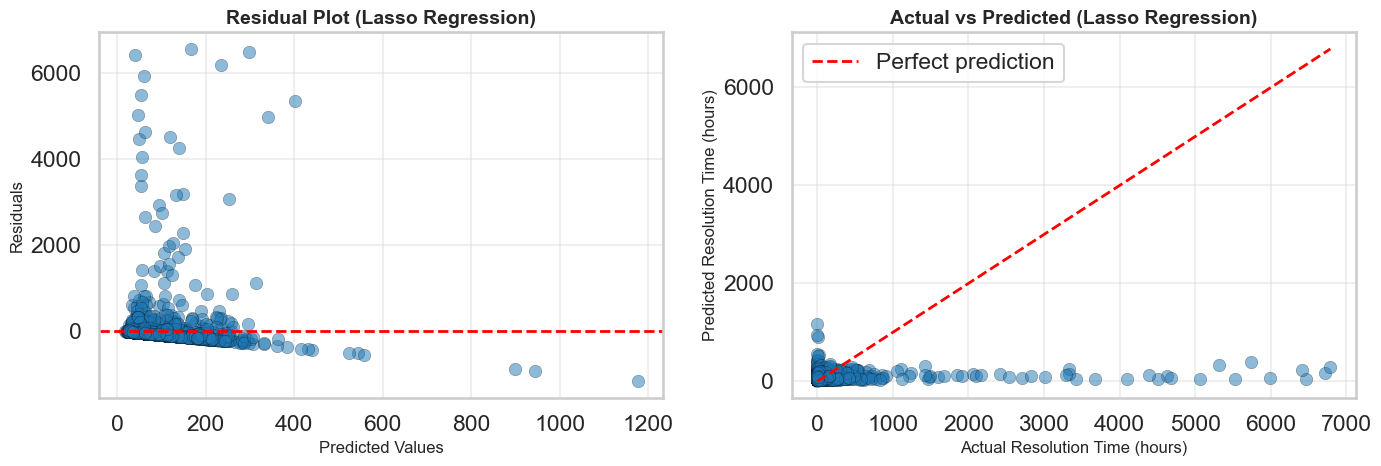

In [37]:
# Residual plot for best model (Lasso)
y_pred_best = pipeline_lasso.predict(X_test)
residuals = y_test - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(y_pred_best, residuals, alpha=0.5, edgecolors='black', linewidth=0.3)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residual Plot (Lasso Regression)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Actual vs Predicted
axes[1].scatter(y_test, y_pred_best, alpha=0.5, edgecolors='black', linewidth=0.3)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('Actual Resolution Time (hours)', fontsize=12)
axes[1].set_ylabel('Predicted Resolution Time (hours)', fontsize=12)
axes[1].set_title('Actual vs Predicted (Lasso Regression)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

##  Key Findings

1. **Overall Performance**  
   Across all the regression models we tried, the results show that our current features explain very little of the variation in how long it takes for questions to be resolved. The R² values were below 0.02, meaning the structured attributes we extracted (like code presence, question length, views, and replies) alone can’t fully capture the real factors behind resolution time.

2. **Model Comparison**  
   Out of all the models — Simple Linear, Multiple Linear, Polynomial, and Lasso — the **Lasso Regression** performed slightly better with an **R² of 0.018** and a **Mean Absolute Error (MAE)** of around **119 hours**. The improvements across models were small, suggesting that adding more complex models without deeper data doesn’t help much at this stage.

3. **Feature Influence**  
   Features such as **question length**, **presence of code blocks**, and **view count** seemed to matter more than basic categorical indicators like whether the post was CUDA-related. This means that the way people write and engage with their posts may be more important than just the topic itself.

4. **Interaction & Nonlinear Effects**  
   When we added interaction and nonlinear terms — like the combination of `CUDA × Code Block` and `Question Length²` — we saw only a very small improvement. This suggests that CUDA posts with code snippets behave a bit differently, but not strongly enough to change the overall results in a big way.

5. **Why Regression Alone Isn’t Enough**  
   Our models show associations, but they don’t tell us **why** those associations exist. For example, CUDA-related posts might take longer to resolve — but is it because they’re truly harder, or because they tend to have longer descriptions, more technical errors, or fewer experts available to answer them?  
   These hidden factors (called **confounders**) make it difficult to say what’s *causing* the delay just by looking at correlations.

6. **Why We Need Causal Models**  
   To really understand if CUDA itself *causes* longer resolution times, we need to go beyond correlation and use **causal inference methods**.  
   Causal models (like DoWhy or causal DAGs) can help us simulate “what if” situations — for instance:  
   *What if a CUDA post didn’t include a code snippet? Would it still take the same amount of time to resolve?*  
   This kind of reasoning helps identify the actual drivers of resolution delay, rather than just patterns in the data.

7. **Next Steps**  
   Going forward, we plan to include **semantic features** (like embeddings from the text content) and **user-level factors** (such as reputation or experience) to capture deeper relationships. Combining those with causal modeling will help us move from simply describing what happens to explaining *why* it happens — which is the core goal of our project.

In [38]:
# Save best model
import pickle

with open('../data/models/multiple_regression_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("Model saved to: ../data/models/multiple_regression_model.pkl")

Model saved to: ../data/models/multiple_regression_model.pkl
